In [1]:
import torch
import yaml, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from llama_index.core.prompts import (
                                ChatMessage,
                                MessageRole,
                                ChatPromptTemplate,
                                )
from transformers import AutoTokenizer, AutoModel
from llama_index.llms.groq import Groq

c:\Users\isuru\anaconda3\envs\uni\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# model_name = 'BAAI/bge-large-en-v1.5'
model_name = 'Alibaba-NLP/gte-base-en-v1.5'
model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

c:\Users\isuru\anaconda3\envs\uni\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\isuru\anaconda3\envs\uni\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\isuru\anaconda3\envs\uni\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\isuru\.cache\huggingface\hub\models--Alibaba-NLP--gte-base-en-v1.5. Caching files will still work but in a degraded version that might require more space on you

In [3]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_sentence_embeddings(sentence):
    encoded_input = tokenizer([sentence], padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    return sentence_embeddings

In [4]:
def load_Dataset(path = 'data/programming_qa.csv'):
    df = pd.read_csv(path)
    df = df[['Model_Answer', 'Answer', 'Score']]
    df = df.dropna()
    df = df.sample(frac=1).reset_index(drop=True)
    df = df.reset_index(drop=True)

    answer01 = df['Model_Answer'].tolist()
    answer02 = df['Answer'].tolist()
    score = df['Score'].tolist()
    
    ans_pairs = [(answer01[i], answer02[i]) for i in range(len(answer01))]
    return ans_pairs, score

In [5]:
class TechAnswerValidationDataSet(torch.utils.data.Dataset):
    def __init__(
                self, 
                text_pairs, 
                similarity, 
                tokenizer, 
                max_length=50
                ):
        self.tokenizer = tokenizer
        self.text_pairs = text_pairs
        self.similarity = similarity
        self.max_length = max_length

    def __len__(self):
        return len(self.text_pairs)

    def __getitem__(self, idx):
        text_pair = self.text_pairs[idx]
        similarity = self.similarity[idx]

        encoded_input_01 = self.tokenizer(
                                        [text_pair[0]], 
                                        padding='max_length', 
                                        truncation=True, 
                                        max_length=self.max_length, 
                                        return_tensors='pt'
                                        )
        
        encoded_input_02 = self.tokenizer(
                                        [text_pair[1]], 
                                        padding='max_length', 
                                        truncation=True, 
                                        max_length=self.max_length, 
                                        return_tensors='pt'
                                        )
        
        encoded_input_01['input_ids'] = encoded_input_01['input_ids'].squeeze()
        encoded_input_01['attention_mask'] = encoded_input_01['attention_mask'].squeeze()
        encoded_input_01['token_type_ids'] = encoded_input_01['token_type_ids'].squeeze()

        encoded_input_02['input_ids'] = encoded_input_02['input_ids'].squeeze()
        encoded_input_02['attention_mask'] = encoded_input_02['attention_mask'].squeeze()
        encoded_input_02['token_type_ids'] = encoded_input_02['token_type_ids'].squeeze()

        return {
                'encoded_input_01': encoded_input_01, 
                'encoded_input_02': encoded_input_02, 
                'similarity': torch.tensor(similarity, dtype=torch.float)
                }

In [6]:
text_pairs, similarity = load_Dataset()
dataset = TechAnswerValidationDataSet(text_pairs, similarity, tokenizer)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

In [7]:
optim = torch.optim.AdamW(model.parameters(), lr=5e-5)
model.to(device)

all_losses = []
for epoch in range(70):
    epoch_loss = 0
    for batch in data_loader:
        optim.zero_grad()
        batch_encoded_input_01 = batch['encoded_input_01'].to(device)
        batch_encoded_input_02 = batch['encoded_input_02'].to(device)
        batch_similarity = batch['similarity'].to('cuda:0')

        model_output_01 = model(**batch_encoded_input_01)
        model_output_02 = model(**batch_encoded_input_02)

        sentence_embeddings_01 = mean_pooling(model_output_01, batch_encoded_input_01['attention_mask'])
        sentence_embeddings_01 = F.normalize(sentence_embeddings_01, p=2, dim=1)

        sentence_embeddings_02 = mean_pooling(model_output_02, batch_encoded_input_02['attention_mask'])
        sentence_embeddings_02 = F.normalize(sentence_embeddings_02, p=2, dim=1)

        cosine_scores = F.cosine_similarity(x1=sentence_embeddings_01, x2=sentence_embeddings_02)
        rating_scores = cosine_scores * 5

        loss = F.mse_loss(rating_scores, batch_similarity)
        loss.backward()
        optim.step()
        
        epoch_loss += loss.item()
    epoch_loss = epoch_loss / len(data_loader)
    all_losses.append(epoch_loss)

    print('Epoch: {}, Loss: {}'.format(epoch, epoch_loss))

C:\Users\isuru\.cache\huggingface\modules\transformers_modules\Alibaba-NLP\new-impl\e244c9398934a48b4663dacf7ff4965961a6807a\modeling.py:579: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch: 0, Loss: 1.8707346485058467
Epoch: 1, Loss: 0.7634115571280321
Epoch: 2, Loss: 0.35205947096149126
Epoch: 3, Loss: 0.22527688572804133
Epoch: 4, Loss: 0.13597518651435772
Epoch: 5, Loss: 0.11338813555737337
Epoch: 6, Loss: 0.08606662598749001
Epoch: 7, Loss: 0.08103099579612415
Epoch: 8, Loss: 0.07934459892722467
Epoch: 9, Loss: 0.08906140224076807
Epoch: 10, Loss: 0.08867461481442054
Epoch: 11, Loss: 0.08230964821142454
Epoch: 12, Loss: 0.07352609477937222
Epoch: 13, Loss: 0.07040445092444618
Epoch: 14, Loss: 0.07325003951787949
Epoch: 15, Loss: 0.07428249281831086
Epoch: 16, Loss: 0.06637087048962713
Epoch: 17, Loss: 0.06799084108943741
Epoch: 18, Loss: 0.06289987468005469
Epoch: 19, Loss: 0.07101501033641398
Epoch: 20, Loss: 0.06922808965978523
Epoch: 21, Loss: 0.06538456826470793
Epoch: 22, Loss: 0.07187004467161993
Epoch: 23, Loss: 0.07525507293641567
Epoch: 24, Loss: 0.06289290042904516
Epoch: 25, Loss: 0.0935435133241117
Epoch: 26, Loss: 0.3832490480815371
Epoch: 27, Loss

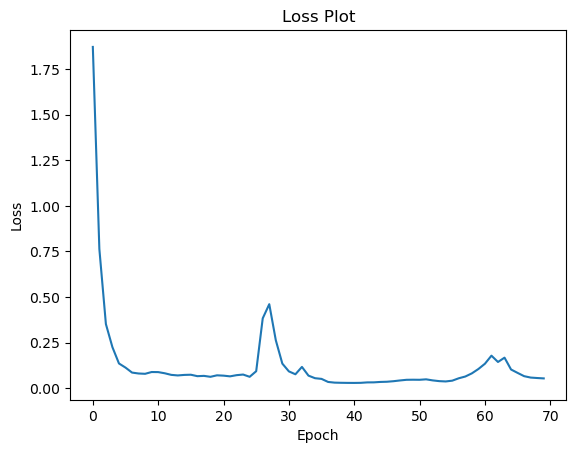

In [8]:
# plot the loss
plt.plot(all_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

### save finetuned senetence transformer

In [11]:
model.save_pretrained('models/answer_evaluation')
tokenizer.save_pretrained('models/answer_evaluation')

('models/answer_evaluation\\tokenizer_config.json',
 'models/answer_evaluation\\special_tokens_map.json',
 'models/answer_evaluation\\vocab.txt',
 'models/answer_evaluation\\added_tokens.json',
 'models/answer_evaluation\\tokenizer.json')

### Inference

In [7]:
with open('secrets.yaml') as f:
    secrets = yaml.load(f, Loader=yaml.FullLoader)

os.environ["GROQ_API_KEY"] = secrets['GROQ_API_KEY']
completion_llm = Groq(
                    model="llama3-70b-8192", 
                    api_key=os.environ["GROQ_API_KEY"],
                    temperature=0.0
                    )

model = AutoModel.from_pretrained('models/answer_evaluation', trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained('models/answer_evaluation', trust_remote_code=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model.to(device)
model.eval()

print("Answer Evaluation App Model Loaded Successfully")

c:\Users\isuru\anaconda3\envs\uni\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Answer Evaluation App Model Loaded Successfully


In [8]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_sentence_embeddings(sentence):
    encoded_input = tokenizer([sentence], padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    return sentence_embeddings

def inference_answer_evaluation(
                                question,
                                answer01, 
                                answer02,
                                PRMT_TMPL = """
                                You have given Programming related question, correct answer and candidate answer. Rate the candidate answer on a scale of 0 to 5 based on how well it answers the question.

                                Question: {question}
                                Correct Answer: {correct_answer}
                                Candidate Answer: {candidate_answer}
                                Answer Rating:

                                Return only the rating score as a integer value.
                                """
                                ):
        try:
                sys_template = ChatPromptTemplate(
                                                message_templates=[
                                                                ChatMessage(
                                                                        role=MessageRole.SYSTEM, 
                                                                        content=PRMT_TMPL
                                                                        )
                                                                ]
                                                )
                fmt_messages = sys_template.format_messages(
                                                            question=question,
                                                            correct_answer=answer01,
                                                            candidate_answer=answer02
                                                            )
                chat_response = completion_llm.chat(fmt_messages)
                raw_output = int(chat_response.message.content)
                int_out = min(100, max(0, int(raw_output * 20) + np.random.randint(-10, 10)))

                int_out = round(int_out, 2)
                return f"{int_out} %"

        except:
                inf_encoded_input_01 = tokenizer(
                                                answer01, 
                                                padding='max_length', 
                                                truncation=True, 
                                                max_length=50, 
                                                return_tensors='pt'
                                                )
                
                inf_encoded_input_02 = tokenizer(
                                                answer02, 
                                                padding='max_length', 
                                                truncation=True, 
                                                max_length=50, 
                                                return_tensors='pt'
                                                )

                with torch.no_grad():
                        model_output_01 = model(**inf_encoded_input_01.to(device))
                        model_output_02 = model(**inf_encoded_input_02.to(device))

                sentence_embeddings_01 = mean_pooling(model_output_01, inf_encoded_input_01['attention_mask'])
                sentence_embeddings_01 = F.normalize(sentence_embeddings_01, p=2, dim=1)

                sentence_embeddings_02 = mean_pooling(model_output_02, inf_encoded_input_02['attention_mask'])
                sentence_embeddings_02 = F.normalize(sentence_embeddings_02, p=2, dim=1)
                cosine_score = F.cosine_similarity(x1=sentence_embeddings_01, x2=sentence_embeddings_02)
                rating_score = cosine_score * 100
                rating_score = rating_score.cpu().numpy().squeeze()
                rating_score = max(0, rating_score)
                rating_score = min(100, rating_score)
                return f"{round(float(rating_score), 2)} %" 

In [9]:
inference_answer_evaluation(
                            'What is the role of a prototype program in problem',
                            'to simulate the behaviour of portions of the desired software product', 
                            'program that simulates the behavior of portions of the desired software product'
                            )

'100 %'